In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


In [3]:
house_prices_df.sort_values(by='saleprice', ascending=False)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000
1169,1170,60,RL,118.0,35760,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,7,2006,WD,Normal,625000
898,899,20,RL,100.0,12919,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,3,2010,New,Partial,611657
803,804,60,RL,107.0,13891,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2009,New,Partial,582933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,31,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,7,2008,WD,Normal,40000
533,534,20,RL,50.0,5000,Pave,None,Reg,Low,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,39300
968,969,50,RM,50.0,5925,Pave,None,Reg,Lvl,AllPub,...,0,None,GdWo,None,0,5,2009,WD,Abnorml,37900
916,917,20,C (all),50.0,9000,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,10,2006,WD,Abnorml,35311


In [4]:
house_prices_df.info()
#use merge on yr and run model w/ ir.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [5]:
house_prices_df.mosold.unique()

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6])

In [6]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)


In [7]:
house_prices_df['totalsf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

house_prices_df['int_over_sf'] = house_prices_df['totalsf'] * house_prices_df['overallqual']

# Y is the target variable
Y = np.log1p(house_prices_df['saleprice'])
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf'] + dummy_column_names]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [8]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8321322553132751
-----Test set statistics-----
R-squared of the model in test set is: 0.8249302330916437
Mean absolute error of the prediction is: 0.1257037287286155
Mean squared error of the prediction is: 0.029192121871356887
Root mean squared error of the prediction is: 0.17085702172096084
Mean absolute percentage error of the prediction is: 1.0503577667823614


In [9]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8319394287042419
-----Test set statistics-----
R-squared of the model in test set is: 0.8226434437869413
Mean absolute error of the prediction is: 0.12624310826908405
Mean squared error of the prediction is: 0.02957343403767702
Root mean squared error of the prediction is: 0.1719692822502816
Mean absolute percentage error of the prediction is: 1.0552354946577744


In [10]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 1.0
R-squared of the model in training set is: 0.8316364867222636
-----Test set statistics-----
R-squared of the model in test set is: 0.8203050076234273
Mean absolute error of the prediction is: 0.1267363733974109
Mean squared error of the prediction is: 0.029963358092979078
Root mean squared error of the prediction is: 0.1730992723640948
Mean absolute percentage error of the prediction is: 1.0596941230310697


In [11]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.001
R-squared of the model in training set is: 0.82996548068038
-----Test set statistics-----
R-squared of the model in test set is: 0.8149185869526185
Mean absolute error of the prediction is: 0.12770726087011358
Mean squared error of the prediction is: 0.030861520302533817
Root mean squared error of the prediction is: 0.17567447254092958
Mean absolute percentage error of the prediction is: 1.0685444897303118


In [12]:
#According to the results, the best model is the OLS regression.

In [13]:
interest_df = pd.read_csv(r'/Users/alexanderheinz/Downloads/MORTGAGE30US.csv')

In [14]:
interest_df.head()

,DATE,MORTGAGE30US
0,2006-01-05,6.21
1,2006-01-12,6.15
2,2006-01-19,6.10
3,2006-01-26,6.12
4,2006-02-02,6.23


In [15]:
interest_df.dtypes

DATE             object
MORTGAGE30US    float64
dtype: object

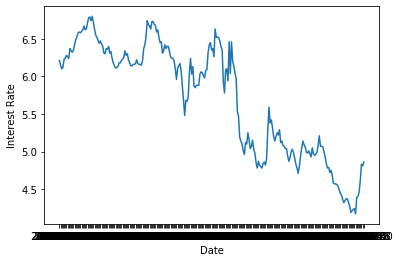

In [16]:
plt.plot(interest_df.DATE, interest_df.MORTGAGE30US)
plt.xlabel('Date')
plt.ylabel('Interest Rate')

plt.show()

In [17]:
interest_df.dropna(inplace = True)

In [19]:
new = interest_df['DATE'].str.split('-', n=2, expand = True)
interest_df['Year'] = new[0]
interest_df['Month'] = new[1]
interest_df['Day'] = new[2]
interest_df.drop(columns='DATE', inplace = True)
interest_df

,MORTGAGE30US,Year,Month,Day
0,6.21,2006,01,05
1,6.15,2006,01,12
2,6.10,2006,01,19
3,6.12,2006,01,26
4,6.23,2006,02,02
...,...,...,...,...
256,4.46,2010,12,02
257,4.61,2010,12,09
258,4.83,2010,12,16
259,4.81,2010,12,23


In [23]:
house_prices_df.yrsold.dtypes

dtype('int64')

In [39]:
#drinks['beer_servings'] = drinks.beer_servings.astype(float)
interest_df['Year'] = interest_df.Year.astype(int)
interest_df['Month'] = interest_df.Month.astype(int)
interest_df.dtypes

MORTGAGE30US    float64
Year              int64
Month             int64
Day              object
dtype: object

In [40]:
interest_df.Month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [42]:
new_df = pd.merge(house_prices_df, interest_df, how='left', left_on=['yrsold', 'mosold'], right_on=['Year', 'Month'])

In [45]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 0 to 6391
Data columns (total 92 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6392 non-null   int64  
 1   mssubclass     6392 non-null   int64  
 2   mszoning       6392 non-null   object 
 3   lotfrontage    5256 non-null   float64
 4   lotarea        6392 non-null   int64  
 5   street         6392 non-null   object 
 6   alley          390 non-null    object 
 7   lotshape       6392 non-null   object 
 8   landcontour    6392 non-null   object 
 9   utilities      6392 non-null   object 
 10  lotconfig      6392 non-null   object 
 11  landslope      6392 non-null   object 
 12  neighborhood   6392 non-null   object 
 13  condition1     6392 non-null   object 
 14  condition2     6392 non-null   object 
 15  bldgtype       6392 non-null   object 
 16  housestyle     6392 non-null   object 
 17  overallqual    6392 non-null   int64  
 18  overallc

In [47]:
pd.set_option('display.max_columns', 500)
new_df.sort_values(by='saleprice', ascending=False)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,totalsf,int_over_sf,MORTGAGE30US,Year,Month,Day
3005,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,None,None,None,0,1,2007,WD,Normal,755000,0,0,1,0,1,6760,67600,6.18,2007,1,04
3007,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,None,None,None,0,1,2007,WD,Normal,755000,0,0,1,0,1,6760,67600,6.23,2007,1,18
3008,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,None,None,None,0,1,2007,WD,Normal,755000,0,0,1,0,1,6760,67600,6.25,2007,1,25
3006,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,None,None,None,0,1,2007,WD,Normal,755000,0,0,1,0,1,6760,67600,6.21,2007,1,11
5170,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000,0,0,1,0,1,6872,68720,6.69,2007,7,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3989,917,20,C (all),50.0,9000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,3,1949,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,50,Unf,0,430,480,GasA,TA,N,FuseA,480,0,0,480,1,0,0,0,1,1,TA,4,Typ,0,None,Detchd,1958.0,Unf,1,308,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,10,2006,WD,Abnorml,35311,0,0,0,0,1,960,1920,6.30,2006,10,05
2158,496,30,C (all),60.0,7879,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,4,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,495,Unf,0,225,720,GasA,TA,N,FuseA,720,0,0,720,0,0,1,0,2,1,TA,4,Typ,0,None,None,NaN,None,0,0,None,None,N,0,523,115,0,0,0,None,GdWo,None,0,11,2009,WD,Abnorml,34900,0,0,0,0,1,1440,5760,4.98,2009,11,05
2159,496,3

In [48]:
new_df = pd.concat([new_df,pd.get_dummies(new_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
new_df = pd.concat([new_df,pd.get_dummies(new_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(new_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(new_df.street, prefix="street", drop_first=True).columns)

In [49]:
new_df['totalsf'] = new_df['totalbsmtsf'] + new_df['firstflrsf'] + new_df['secondflrsf']

new_df['int_over_sf'] = new_df['totalsf'] * new_df['overallqual']

# Y is the target variable
Y = np.log1p(new_df['saleprice'])
# X is the feature set
X = new_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf', 'MORTGAGE30US'] + dummy_column_names]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [50]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8295033432433853
-----Test set statistics-----
R-squared of the model in test set is: 0.8398777202299047
Mean absolute error of the prediction is: 0.11720779823278485
Mean squared error of the prediction is: 0.02615312333915396
Root mean squared error of the prediction is: 0.1617192732458131
Mean absolute percentage error of the prediction is: 0.9770449063770319


In [51]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-05
R-squared of the model in training set is: 0.8295017107300356
-----Test set statistics-----
R-squared of the model in test set is: 0.8399259268996592
Mean absolute error of the prediction is: 0.11719276213838266
Mean squared error of the prediction is: 0.026145249637994646
Root mean squared error of the prediction is: 0.16169492768171376
Mean absolute percentage error of the prediction is: 0.9769239128227423


In [52]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 1.0
R-squared of the model in training set is: 0.8294770806621924
-----Test set statistics-----
R-squared of the model in test set is: 0.8399770902735466
Mean absolute error of the prediction is: 0.1172222997758353
Mean squared error of the prediction is: 0.026136893011860864
Root mean squared error of the prediction is: 0.16166908489832205
Mean absolute percentage error of the prediction is: 0.9771967033683238


In [53]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8294505266755241
-----Test set statistics-----
R-squared of the model in test set is: 0.8400923397027296
Mean absolute error of the prediction is: 0.1172063114649364
Mean squared error of the prediction is: 0.02611806906968046
Root mean squared error of the prediction is: 0.16161085690534674
Mean absolute percentage error of the prediction is: 0.9770699221187201


In [ ]:
#It seems like on (almost) every account. The Error of the prediction
#is smaller! Seems like adding Interest rates were a great idea!!!
#I had to do some cleaning, and merging, and organizing but I think
#it was all worth it!